# Model

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler,OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,recall_score, make_scorer

from sklearn.feature_selection import RFECV

from catboost import CatBoostClassifier

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where


DEBUG = False
SEED = 666

## Load Data

### Data for predictions

In [2]:
df_churn_test = pd.read_pickle("./orig/data/churn_test.pkl")
print(df_churn_test.shape)
df_churn_test.head(1)

(3542, 20)


,Current,Deposit,Investment,Joint,Loan,Mortgage,On Demand Deposit,Card,Customer_Service_Calls,Credit_Limit,Average_Utilisation_Ratio,Age,Education,Marital_Status,Dependents,Income,Total_Transactions,Avg_Transaction,Num_Transactions,Loyalty
Customer,,,,,,,,,,,,,,,,,,,,
708182832,1,1,1,0,0,0,0,1,1,3375.0,0.513,37,5,Single,2,2,4341.01,67.828281,64,824


### Training data

In [3]:
df = pd.read_pickle("./orig/data/churn_train.pkl")
print(df.shape)
df.head(1)

(5831, 21)


,Current,Deposit,Investment,Joint,Loan,Mortgage,On Demand Deposit,Churn,Card,Customer_Service_Calls,...,Average_Utilisation_Ratio,Age,Education,Marital_Status,Dependents,Income,Total_Transactions,Avg_Transaction,Num_Transactions,Loyalty
Customer,,,,,,,,,,,,,,,,,,,,,
708115009,0,0,0,0,0,0,0,Yes,1,3,...,0.0,47.0,1,Single,3,1,1886.99,52.416389,36,1159


In [4]:
df.dtypes

Current                         int64
Deposit                         int64
Investment                      int64
Joint                           int64
Loan                            int64
Mortgage                        int64
On Demand Deposit               int64
Churn                        category
Card                            int64
Customer_Service_Calls          int64
Credit_Limit                  float64
Average_Utilisation_Ratio     float64
Age                           float64
Education                       int64
Marital_Status               category
Dependents                      int64
Income                          int64
Total_Transactions            float64
Avg_Transaction               float64
Num_Transactions                int64
Loyalty                         int64
dtype: object

#### Features and Target

In [5]:
target = "Churn"
cat_features = [c for c in df.select_dtypes("category").columns if c not in target]
num_features = [c for c in df.select_dtypes(["int","float"]).columns if c not in target]
features = cat_features + num_features


print(f"Target: {target}")

print(f"Categorical Features: {cat_features}")
print(f"Numerical Features: {num_features}")

Target: Churn
Categorical Features: ['Marital_Status']
Numerical Features: ['Current', 'Deposit', 'Investment', 'Joint', 'Loan', 'Mortgage', 'On Demand Deposit', 'Card', 'Customer_Service_Calls', 'Credit_Limit', 'Average_Utilisation_Ratio', 'Age', 'Education', 'Dependents', 'Income', 'Total_Transactions', 'Avg_Transaction', 'Num_Transactions', 'Loyalty']


## Check Target Values

In [6]:
df[target].value_counts()

No     4919
Yes     912
Name: Churn, dtype: int64

In [7]:
df.isna().sum().sum()

0

### Comments
- From the relative frequencies above we can see clearly that the dataset is unbalanced.
- We will attempt to use a Synthetic Minority Oversampling Technique (SMOTE) to balance out the dataset later on.

## Encode Categorical Values

### Train-Test Split

In [8]:
df_train, df_test, y_train, y_test = train_test_split(df[features], df[target], train_size=0.6, stratify=df[target], random_state=SEED)
df_train.shape, df_test.shape

((3498, 20), (2333, 20))

## Encoding Values

In [9]:
def encode_df(df_train, y_train):
    cat_e = OneHotEncoder()
    num_e = StandardScaler()
    
    data = cat_e.fit_transform(df_train[cat_features]).toarray()
    index = df_train.index
    columns = cat_e.get_feature_names_out()
    df_cat = pd.DataFrame(data=data, index=index, columns=columns)

    data = num_e.fit_transform(df_train[num_features])
    index = df_train.index
    columns = num_features
    df_num = pd.DataFrame(data=data, index=index, columns=num_features)
    df_num = df_train[num_features]
    
    df_train = pd.concat([df_cat, df_num], axis=1)
    
    y_train = y_train.map( {'No':0, "Yes":1} )
    
    return df_train, y_train

### Encode churn pred dataframe

In [10]:
df_churn_test["Churn"] = "No"
df_churn_test , y_churn = encode_df(df_churn_test.iloc[:, :-1],df_churn_test["Churn"])
df_churn_test.head(1)
#np.unique(df_churn_test.Marital_Status_Unknown)

,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Current,Deposit,Investment,Joint,Loan,Mortgage,...,Credit_Limit,Average_Utilisation_Ratio,Age,Education,Dependents,Income,Total_Transactions,Avg_Transaction,Num_Transactions,Loyalty
Customer,,,,,,,,,,,,,,,,,,,,,
708182832,0.0,0.0,1.0,0.0,1,1,1,0,0,0,...,3375.0,0.513,37,5,2,2,4341.01,67.828281,64,824


### Encode Train

In [11]:
df_train, y_train = encode_df(df_train,y_train)
df_train.insert(loc=16, column='Marital_Status_Unknown',value=0)
display(df_train.head(1))

,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Current,Deposit,Investment,Joint,Loan,Mortgage,On Demand Deposit,...,Average_Utilisation_Ratio,Age,Education,Marital_Status_Unknown,Dependents,Income,Total_Transactions,Avg_Transaction,Num_Transactions,Loyalty
Customer,,,,,,,,,,,,,,,,,,,,,
793319878,0.0,1.0,0.0,1,1,0,0,0,0,0,...,0.603,51.0,5,0,3,2,4798.03,65.726438,73,1190


#### Comment:
- OHE still doesnt add columns for categorical values that dont show up in a dataframe so we have to manually add in a marital status column to match the testing dataframe for churn

### Encode Test

In [12]:
df_test, y_test = encode_df(df_test, y_test)
df_test.insert(loc=16, column='Marital_Status_Unknown',value=0)
display(df_test.head(1))

,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Current,Deposit,Investment,Joint,Loan,Mortgage,On Demand Deposit,...,Average_Utilisation_Ratio,Age,Education,Marital_Status_Unknown,Dependents,Income,Total_Transactions,Avg_Transaction,Num_Transactions,Loyalty
Customer,,,,,,,,,,,,,,,,,,,,,
767479181,0.0,1.0,0.0,1,1,1,0,0,0,0,...,0.099,47.0,3,0,3,0,1593.04,34.631304,46,1404


### Feature Selection

In [13]:
models = {
    "LR": LogisticRegression(max_iter=1000),
    "DT": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "RF": RandomForestClassifier(),
    "ET": ExtraTreesClassifier(),
    #"XGB": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED),
    "CLF": CatBoostClassifier(silent=True),
    "ADA": AdaBoostClassifier(n_estimators=100,random_state=SEED),
    "GBRT": GradientBoostingClassifier(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)

    
}

scorer = make_scorer(recall_score)

Optimal number of features : 19


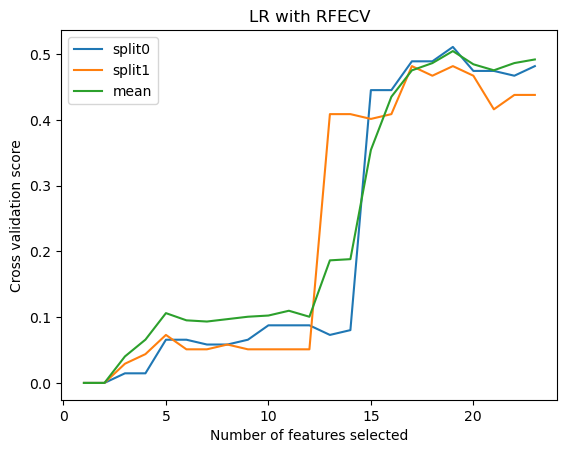

In [14]:
name = 'LR'  # use any LR, DT
model = models[name]

rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(4), scoring=scorer)
rfecv.fit(df_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.title(f"{name} with RFECV")
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
results = rfecv.cv_results_
plt.plot(range(1, len(results['mean_test_score']) + 1), results['split0_test_score'], label='split0')
plt.plot(range(1, len(results['mean_test_score']) + 1), results['split1_test_score'], label='split1')
plt.plot(range(1, len(results['mean_test_score']) + 1), results['mean_test_score'], label='mean')
plt.legend()
plt.show()

In [15]:
if len(rfecv.support_)<len(df_train.columns):
    print("It looks like you have run cells out of order. Runn cells from Pre-Processing Data (2)")

features_selected = np.array(df_train.columns)[rfecv.support_].tolist()
features_selected

['Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Current',
 'Deposit',
 'Investment',
 'Joint',
 'Loan',
 'Mortgage',
 'On Demand Deposit',
 'Card',
 'Customer_Service_Calls',
 'Average_Utilisation_Ratio',
 'Age',
 'Education',
 'Dependents',
 'Income',
 'Avg_Transaction',
 'Num_Transactions']

### SMOTE

#### Define Pipeline

In [16]:
over = SMOTE(sampling_strategy=0.7)
under = RandomUnderSampler(sampling_strategy=0.4)
#steps = [('o', over),('u',under)]
steps = [('o', over)]
pipeline = Pipeline(steps=steps)

#### Applying Smote to balance datasest

In [17]:
#X_smote, y_smote = pipeline.fit_resample(df_train,y_train)
X_smote, y_smote = pipeline.fit_resample(df_train[features_selected],y_train)

/home/PStefans/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/PStefans/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


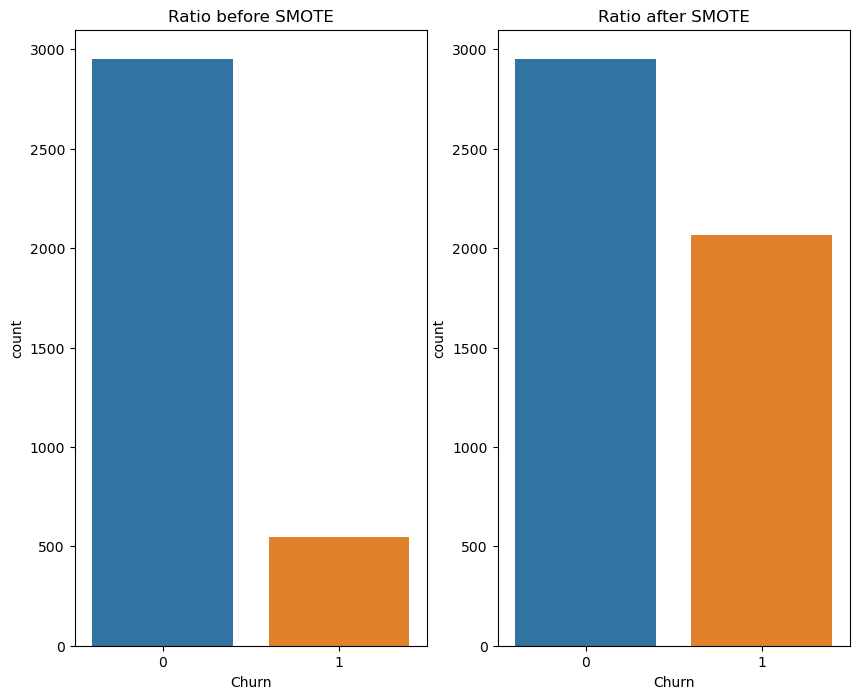

Counter({0: 2951, 1: 2065})

In [18]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
sns.countplot(y_train)
plt.title('Ratio before SMOTE')
plt.subplot(1, 2, 2)
sns.countplot(y_smote)
plt.title('Ratio after SMOTE')
plt.show()
Counter(y_smote)

### Model Selection

In [19]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
for name,model in models.items():
    scores = cross_val_score(model, df_train, y_train, cv=cv, scoring=scorer)
    #scores = cross_val_score(model, df_train[features_selected], y_train, cv=cv, scoring=scorer)
    #scores = cross_val_score(model, X_smote, y_smote, cv=cv, scoring=scorer)
    print(name, "Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

LR Recall: 0.46 (+/- 0.13)
DT Recall: 0.72 (+/- 0.11)
KNN Recall: 0.45 (+/- 0.14)
RF Recall: 0.71 (+/- 0.11)
ET Recall: 0.54 (+/- 0.15)
CLF Recall: 0.79 (+/- 0.09)
ADA Recall: 0.74 (+/- 0.13)
GBRT Recall: 0.59 (+/- 0.17)


In [20]:
model = CatBoostClassifier(silent=True)
model.fit(df_train, y_train)
#model.fit(df_train[features_selected], y_train)
#model.fit(X_smote, y_smote)
y_pred = model.predict(df_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
np.unique(y_pred)

array([0, 1])

In [22]:
def showDiagnostics(y_test, y_pred):
  # Model Accuracy, how often is the classifier correct?
  print("Accuracy:",accuracy_score(y_test, y_pred))
  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))
  print("Classification Report:")
  print(classification_report(y_test, y_pred, digits=3))

In [23]:
showDiagnostics(y_test,y_pred)

Accuracy: 0.9507072438919846
Confusion Matrix:
[[1929   39]
 [  76  289]]
Classification Report:
              precision    recall  f1-score   support

           0      0.962     0.980     0.971      1968
           1      0.881     0.792     0.834       365

    accuracy                          0.951      2333
   macro avg      0.922     0.886     0.903      2333
weighted avg      0.949     0.951     0.950      2333



## Generate predictions

In [24]:
y_pred = model.predict(df_churn_test)

In [25]:
df_pred = pd.DataFrame({'Churn': y_pred}, index=df_churn_test.index)
df_pred = df_pred.Churn.map( {0:'No', 1:"Yes"} )
df_pred = df_pred.reset_index()
print(df_pred.shape)
print(df_pred.head(5))
df_pred.to_csv("./orig/output/pred.csv",index=False)


(3542, 2)
    Customer Churn
0  708182832    No
1  708240660    No
2  708249778    No
3  708259785    No
4  708264579    No


#### Kaggle Scores
- No Feature Engineering - 0.950 - CLF
- Basic Feature Engineering and SMOTE 0.944 -CLF
- SMOTE and Feature Selection - 0.942 CLF
- Feature Engineering Cat to Num, Smote - 0.938 - CLF
- Feature Engineering Cat to Num - 0.952 -CLF